# 2D Differentiable Spatial Relations Solver - Proof of Concept

This notebook demonstrates a differentiable optimization-based solver for spatial relations using PyTorch.

## Overview

- Uses gradient descent to optimize object positions
- Supports two spatial relations:
  - `On(parent)`: Child must stay within parent's AABB bounds
  - `NextTo(parent, side)`: Child positioned adjacent to parent
- Soft constraints with repulsive collision potentials
- Assets can be explicitly marked as `fixed=True` to remain at origin (anchor objects)
- Visualizes final placements with matplotlib


## Section 1: Setup and Imports


In [34]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from dataclasses import dataclass, field
import numpy as np

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")


PyTorch version: 2.7.0+cu128
Device: cuda


## Section 2: Mock Asset Classes


In [53]:
@dataclass
class MockAsset2D:
    """A simple 2D asset with width and length for testing spatial relations."""
    name: str
    width: float   # X dimension
    length: float  # Y dimension
    fixed: bool = False  # If True, asset position won't be optimized
    initial_pos: tuple = (0.0, 0.0, 0.0)  # Initial position (x, y, theta) for fixed assets
    relations: list = field(default_factory=list)
    
    def add_relation(self, *relations):
        """Add one or more spatial relations to this asset."""
        self.relations.extend(relations)
    
    def get_corners(self, pos: torch.Tensor) -> torch.Tensor:
        """Get 4 corners given position [x, y, theta].
        
        For 2D POC, we assume theta=0 (axis-aligned rectangles).
        """
        x, y = pos[0], pos[1]
        return torch.stack([
            torch.tensor([x - self.width/2, y - self.length/2]),
            torch.tensor([x + self.width/2, y - self.length/2]),
            torch.tensor([x + self.width/2, y + self.length/2]),
            torch.tensor([x - self.width/2, y + self.length/2]),
        ])
    
    def __repr__(self):
        return f"MockAsset2D({self.name}, w={self.width}, l={self.length})"

# Test the class
test_asset = MockAsset2D("test_table", width=2.0, length=1.5)
print(f"Created: {test_asset}")
print(f"Corners at (0,0,0): {test_asset.get_corners(torch.tensor([0.0, 0.0, 0.0]))}")


Created: MockAsset2D(test_table, w=2.0, l=1.5)
Corners at (0,0,0): tensor([[-1.0000, -0.7500],
        [ 1.0000, -0.7500],
        [ 1.0000,  0.7500],
        [-1.0000,  0.7500]])


## Section 3: Relation Classes with Loss Functions

Each relation type defines a `compute_loss` method that returns a differentiable loss term.

**Available Relations:**
- `On(parent)`: Ensures child stays within parent's 2D bounding box (hard boundary constraint)
- `NextTo(parent, side)`: Positions child adjacent to parent on specified side


In [54]:
class Relation:
    """Base class for spatial relationships."""
    
    def __init__(self, parent: MockAsset2D):
        self.parent = parent
    
    def compute_loss(self, child_pos, parent_pos, child_asset, parent_asset) -> torch.Tensor:
        """Compute differentiable loss term for this relation."""
        raise NotImplementedError


class On(Relation):
    """Child should be placed within the parent's AABB (bounding box).
    
    In 2D: Child must stay within parent's x,y extents.
    In 3D: Would additionally handle z positioning (height).
    """
    
    def compute_loss(self, child_pos, parent_pos, child_asset, parent_asset):
        """On() relation has no soft constraints - only hard boundary enforcement."""
        # Return zero - On() only contributes through compute_boundary_loss()
        return torch.tensor(0.0)
    
    def compute_boundary_loss(self, child_pos, parent_pos, child_asset, parent_asset):
        """Hard boundary violation loss - penalizes leaving parent bounds."""
        # Extract 2D positions
        child_x, child_y = child_pos[0], child_pos[1]
        parent_x, parent_y = parent_pos[0], parent_pos[1]
        
        # Half-dimensions
        child_hw = child_asset.width / 2
        child_hl = child_asset.length / 2
        parent_hw = parent_asset.width / 2
        parent_hl = parent_asset.length / 2
        
        # Compute how far the child center is from parent center
        dx = torch.abs(child_x - parent_x)
        dy = torch.abs(child_y - parent_y)
        
        # Maximum allowed distance for child center to stay within parent bounds
        max_dx = parent_hw - child_hw
        max_dy = parent_hl - child_hl
        
        # Quadratic penalty for boundary violations (weighted separately in solver)
        violation_x = torch.clamp(dx - max_dx, min=0)
        violation_y = torch.clamp(dy - max_dy, min=0)
        
        return violation_x ** 2 + violation_y ** 2
    
    def __repr__(self):
        return f"On({self.parent.name})"


apple.add_relation(NextTo(table))


class NextTo(Relation):
    """Child should be adjacent to parent on specified side."""
    
    def __init__(self, parent: MockAsset2D, side: str = "right", gap: float = 0.05):
        super().__init__(parent)
        assert side in ["left", "right", "front", "back"], f"Invalid side: {side}"
        self.side = side
        self.gap = gap
    
    def compute_loss(self, child_pos, parent_pos, child_asset, parent_asset):
        target_pos = self._compute_target_position(
            parent_pos, parent_asset, child_asset
        )
        position_diff = child_pos[:2] - target_pos
        return torch.sum(position_diff ** 2)
    
    def _compute_target_position(self, parent_pos, parent_asset, child_asset):
        """Compute the target position for the child asset."""
        px, py = parent_pos[0], parent_pos[1]
        pw, pl = parent_asset.width, parent_asset.length
        cw, cl = child_asset.width, child_asset.length
        
        side_offsets = {
            "right": torch.tensor([pw/2 + self.gap + cw/2, 0.0]),
            "left":  torch.tensor([-pw/2 - self.gap - cw/2, 0.0]),
            "front": torch.tensor([0.0, pl/2 + self.gap + cl/2]),
            "back":  torch.tensor([0.0, -pl/2 - self.gap - cl/2]),
        }
        return parent_pos[:2] + side_offsets[self.side]
    
    def __repr__(self):
        return f"NextTo({self.parent.name}, side={self.side})"


# Test the relation classes
table = MockAsset2D("table", width=2.0, length=1.5)
box = MockAsset2D("box", width=0.3, length=0.3)
small_item = MockAsset2D("small_item", width=0.1, length=0.1)

on_rel = On(table)
nextto_rel = NextTo(box, side="right")

print(f"Created relations: {on_rel}, {nextto_rel}")
small_item.add_relation(on_rel)
box.add_relation(nextto_rel)
print(f"Small item relations: {small_item.relations}")
print(f"Box relations: {box.relations}")


Created relations: On(table), NextTo(box, side=right)
Small item relations: [On(table)]
Box relations: [NextTo(box, side=right)]


## Section 4: Differentiable Solver

The solver uses gradient descent to optimize object positions by minimizing relation losses and collision penalties.


In [55]:
class RelationSolver2D:
    """Differentiable solver for 2D spatial relations using gradient descent."""
    
    def __init__(self, 
                 w_relation=1.0,     # Weight for relation losses (NextTo, etc.)
                 w_boundary=100.0,   # Weight for boundary violations (On relation bounds)
                 w_collision=10.0,   # Weight for collision avoidance
                 max_iters=1000,
                 lr=0.01,
                 convergence_threshold=1e-4,
                 verbose=True):
        self.w_relation = w_relation
        self.w_boundary = w_boundary
        self.w_collision = w_collision
        self.max_iters = max_iters
        self.lr = lr
        self.convergence_threshold = convergence_threshold
        self.verbose = verbose
    
    def solve(self, assets: list[MockAsset2D]) -> dict[str, tuple]:
        """Solve for optimal positions of all assets.
        
        Args:
            assets: List of MockAsset2D objects with relations
            
        Returns:
            Dictionary mapping asset names to (x, y, theta) tuples
        """
        # 1. Initialize positions
        all_positions = self._initialize_positions(assets)
        
        # 2. Identify fixed assets and optimizable assets
        fixed_mask = torch.tensor([asset.fixed for asset in assets])
        optimizable_mask = ~fixed_mask
        
        # Split into fixed and optimizable
        fixed_positions = all_positions[fixed_mask].clone()  # These won't change
        optimizable_positions = all_positions[optimizable_mask].clone()
        optimizable_positions.requires_grad = True
        
        if self.verbose:
            n_fixed = fixed_mask.sum().item()
            n_opt = optimizable_mask.sum().item()
            print(f"Fixed assets: {n_fixed}, Optimizable assets: {n_opt}")
        
        # 3. Setup optimizer (only for optimizable positions)
        optimizer = torch.optim.Adam([optimizable_positions], lr=self.lr)
        
        # 4. Optimization loop
        loss_history = []
        for iter in range(self.max_iters):
            optimizer.zero_grad()
            
            # Reconstruct full position tensor for loss computation
            all_positions = torch.zeros((len(assets), 3))
            all_positions[fixed_mask] = fixed_positions
            all_positions[optimizable_mask] = optimizable_positions
            
            # Compute total loss
            loss = self._compute_total_loss(all_positions, assets)
            loss_history.append(loss.item())
            
            # Backprop and update (only optimizable positions will update)
            loss.backward()
            optimizer.step()
            
            if self.verbose and iter % 100 == 0:
                print(f"Iter {iter}: loss = {loss.item():.6f}")
            
            # Check convergence
            if loss.item() < self.convergence_threshold:
                if self.verbose:
                    print(f"Converged at iteration {iter}")
                break
        
        # 5. Reconstruct final positions
        final_positions = torch.zeros((len(assets), 3))
        final_positions[fixed_mask] = fixed_positions
        final_positions[optimizable_mask] = optimizable_positions.detach()
        
        # 6. Return positions as dict
        result = self._positions_to_dict(final_positions, assets)
        result['_loss_history'] = loss_history
        return result
    
    def _initialize_positions(self, assets):
        """Initialize positions randomly for non-fixed assets."""
        n = len(assets)
        positions = torch.zeros(n, 3)
        
        # Initialize based on whether asset is fixed
        for i, asset in enumerate(assets):
            if asset.fixed:
                # Fixed assets use their specified initial position
                positions[i] = torch.tensor(asset.initial_pos, dtype=torch.float32)
            else:
                # Non-fixed assets get random positions
                # Random position within a reasonable range
                positions[i][:2] = torch.randn(2) * 0.3
                positions[i][2] = 0.0  # No rotation
        
        return positions
    
    def _compute_total_loss(self, positions, assets):
        """Compute weighted sum of all loss terms."""
        rel_loss = self._compute_relation_loss(positions, assets)
        boundary_loss = self._compute_boundary_loss(positions, assets)
        col_loss = self._compute_collision_loss(positions, assets)
        
        total = (self.w_relation * rel_loss + 
                 self.w_boundary * boundary_loss +
                 self.w_collision * col_loss)
        
        return total
    
    def _compute_relation_loss(self, positions, assets):
        """Compute loss from spatial relation constraints (NextTo positioning)."""
        loss = torch.tensor(0.0, requires_grad=True)
        asset_dict = {a.name: (i, a) for i, a in enumerate(assets)}
        
        for i, asset in enumerate(assets):
            for relation in asset.relations:
                parent_idx = asset_dict[relation.parent.name][0]
                rel_loss = relation.compute_loss(
                    positions[i], 
                    positions[parent_idx],
                    asset,
                    relation.parent
                )
                loss = loss + rel_loss
        
        return loss
    
    def _compute_boundary_loss(self, positions, assets):
        """Compute hard boundary violations for On() relations."""
        loss = torch.tensor(0.0, requires_grad=True)
        asset_dict = {a.name: (i, a) for i, a in enumerate(assets)}
        
        for i, asset in enumerate(assets):
            for relation in asset.relations:
                if isinstance(relation, On):
                    parent_idx = asset_dict[relation.parent.name][0]
                    boundary_loss = relation.compute_boundary_loss(
                        positions[i], 
                        positions[parent_idx],
                        asset,
                        relation.parent
                    )
                    loss = loss + boundary_loss
        
        return loss
    
    def _compute_collision_loss(self, positions, assets):
        """Compute repulsive potential for collision avoidance."""
        loss = torch.tensor(0.0, requires_grad=True)
        
        for i in range(len(assets)):
            for j in range(i+1, len(assets)):
                overlap = self._compute_overlap(
                    positions[i], assets[i],
                    positions[j], assets[j]
                )
                # Soft quadratic penalty when overlapping (much less aggressive than exponential)
                # Only penalize when overlap is negative (objects actually overlapping)
                if overlap < 0:
                    # Quadratic penalty proportional to penetration depth
                    loss = loss + overlap ** 2
        
        return loss
    
    def _compute_overlap(self, pos1, asset1, pos2, asset2):
        """Compute minimum separation distance (negative if overlapping)."""
        # For axis-aligned boxes
        dx = torch.abs(pos1[0] - pos2[0])
        dy = torch.abs(pos1[1] - pos2[1])
        
        # Half-widths
        hw1, hl1 = asset1.width / 2, asset1.length / 2
        hw2, hl2 = asset2.width / 2, asset2.length / 2
        
        # Overlap distances
        overlap_x = (hw1 + hw2) - dx
        overlap_y = (hl1 + hl2) - dy
        
        # Return minimum overlap (penetration depth)
        # Negative means no overlap
        if overlap_x > 0 and overlap_y > 0:
            return -torch.min(overlap_x, overlap_y)
        else:
            # No overlap, return positive separation
            return torch.max(-overlap_x, -overlap_y)
    

    def _positions_to_dict(self, positions, assets):
        """Convert position tensor to dictionary."""
        result = {}
        for i, asset in enumerate(assets):
            pos = positions[i].detach().numpy()
            result[asset.name] = tuple(pos)
        return result

print("RelationSolver2D class defined successfully!")


RelationSolver2D class defined successfully!


## Section 5: Visualization


In [56]:
def visualize_scene(positions: dict, assets: dict, title="Scene Layout", figsize=(10, 10)):
    """Visualize the 2D scene layout with rectangles representing assets.
    
    Args:
        positions: Dictionary mapping asset names to (x, y, theta) tuples
        assets: Dictionary mapping asset names to MockAsset2D objects
        title: Plot title
        figsize: Figure size
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Generate colors for each asset
    colors = plt.cm.tab10(np.linspace(0, 1, len(assets)))
    
    # Draw each asset
    for i, (name, pos) in enumerate(positions.items()):
        if name.startswith('_'):  # Skip metadata like '_loss_history'
            continue
            
        asset = assets[name]
        x, y, theta = pos
        
        # Draw rectangle (axis-aligned for now)
        rect = patches.Rectangle(
            (x - asset.width/2, y - asset.length/2),
            asset.width, asset.length,
            linewidth=2, 
            edgecolor=colors[i], 
            facecolor=colors[i], 
            alpha=0.3
        )
        ax.add_patch(rect)
        
        # Add label at center
        ax.text(x, y, name, ha='center', va='center', 
                fontweight='bold', fontsize=10)
        
        # Add dimensions annotation
        ax.text(x, y - asset.length/2 - 0.1, 
                f"({asset.width:.2f} x {asset.length:.2f})", 
                ha='center', va='top', fontsize=8, alpha=0.7)
    
    # Set aspect ratio and grid
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linewidth=0.5, alpha=0.3)
    ax.axvline(x=0, color='k', linewidth=0.5, alpha=0.3)
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    ax.set_title(title)
    
    # Auto-scale with some padding
    ax.autoscale()
    plt.tight_layout()
    plt.show()


def plot_loss_history(positions: dict, title="Optimization Loss"):
    """Plot the loss history from the solver.
    
    Args:
        positions: Dictionary returned by solver (contains '_loss_history' key)
        title: Plot title
    """
    if '_loss_history' not in positions:
        print("No loss history found in positions dictionary")
        return
    
    loss_history = positions['_loss_history']
    
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(loss_history, linewidth=2)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Total Loss')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')  # Log scale often better for loss curves
    plt.tight_layout()
    plt.show()


print("Visualization functions defined successfully!")


Visualization functions defined successfully!


## Section 6: Example Scenarios

Now let's test the solver with some example scenarios!


### Example 1: Simple NextTo Chain

Three boxes positioned relative to each other using NextTo relations.


Fixed assets: 1, Optimizable assets: 2
Iter 0: loss = 0.473829
Iter 100: loss = 0.050744
Iter 200: loss = 0.050299
Iter 300: loss = 0.050298
Iter 400: loss = 0.050298
Iter 500: loss = 0.050298
Iter 600: loss = 0.050298
Iter 700: loss = 0.050298
Iter 800: loss = 0.050298
Iter 900: loss = 0.050298

Final positions:
  box1: x=0.000, y=0.000, theta=0.000
  box2: x=0.400, y=0.155, theta=0.000
  box3: x=0.075, y=0.310, theta=0.000


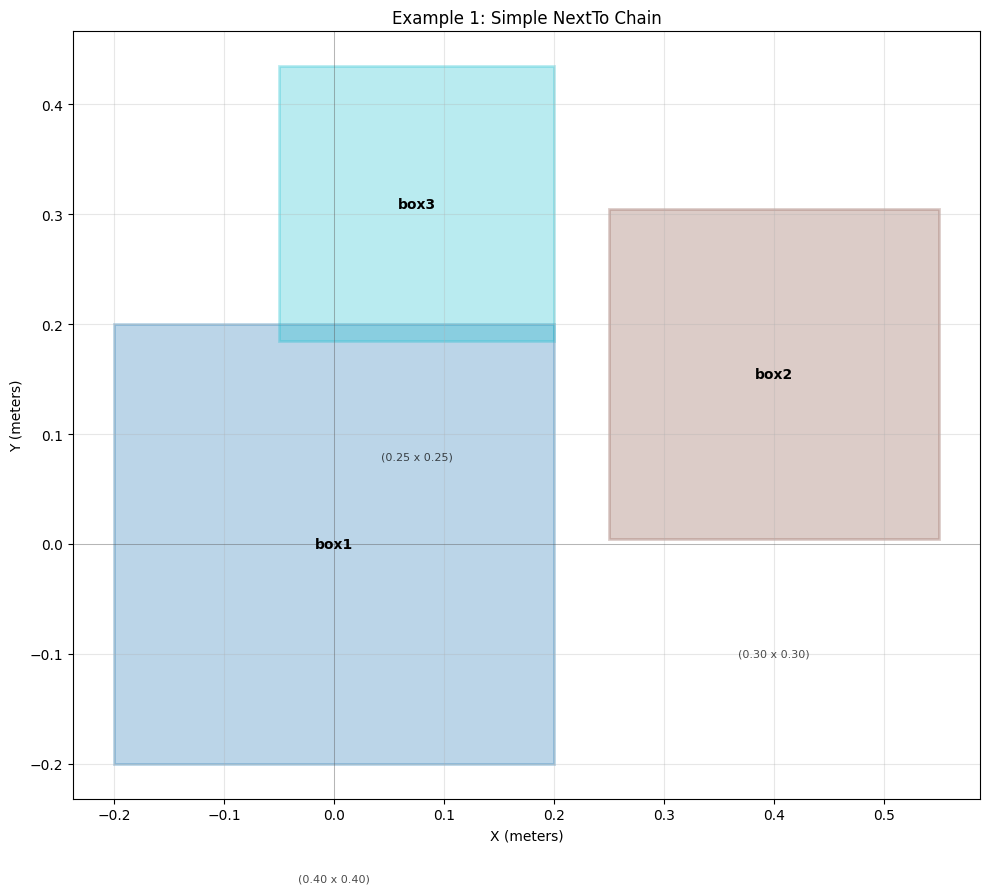

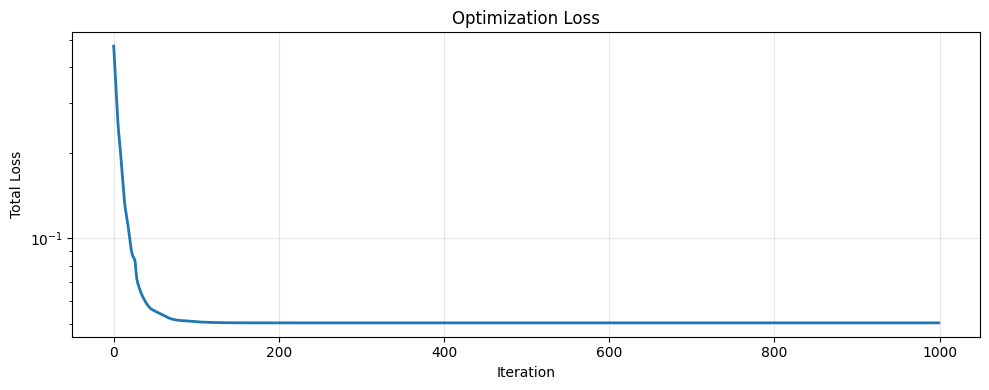

In [57]:
# Create assets
box1 = MockAsset2D("box1", width=0.4, length=0.4, fixed=True)  # Fixed reference point
box2 = MockAsset2D("box2", width=0.3, length=0.3)
box3 = MockAsset2D("box3", width=0.25, length=0.25)

# Define relations - box1 is the root, others position relative to it
box2.add_relation(NextTo(box1, side="right"))
box3.add_relation(NextTo(box2, side="left"))

# Solve
solver = RelationSolver2D()
assets_list = [box1, box2, box3]
positions = solver.solve(assets_list)

print("\nFinal positions:")
for name, pos in positions.items():
    if not name.startswith('_'):
        print(f"  {name}: x={pos[0]:.3f}, y={pos[1]:.3f}, theta={pos[2]:.3f}")

# Visualize
assets_dict = {a.name: a for a in assets_list}
visualize_scene(positions, assets_dict, title="Example 1: Simple NextTo Chain")
plot_loss_history(positions)


### Example 2: Complex Layout

Multiple objects arranged with nested NextTo relations.


In [14]:
# Create assets
microwave = MockAsset2D("microwave", width=0.8, length=0.6)
cracker_box = MockAsset2D("cracker_box", width=0.2, length=0.3)
apple = MockAsset2D("apple", width=0.1, length=0.1)
banana = MockAsset2D("banana", width=0.15, length=0.08)

# Define relations - nested NextTo relations forming a layout
# microwave is the root object at origin
cracker_box.add_relation(NextTo(microwave, side="right"))
apple.add_relation(NextTo(cracker_box, side="right"))
banana.add_relation(NextTo(microwave, side="front"))

# Solve
optimizing_assets_list = [cracker_box, apple, banana]
full_assets_list = [microwave, cracker_box, apple, banana]
solver = RelationSolver2D()
positions = solver.solve(optimizing_assets_list)

print("\nFinal positions:")
for name, pos in positions.items():
    if not name.startswith('_'):
        print(f"  {name}: x={pos[0]:.3f}, y={pos[1]:.3f}, theta={pos[2]:.3f}")

# Visualize
full_assets_dict = {a.name: a for a in full_assets_list}
visualize_scene(positions, full_assets_dict, title="Example 2: Complex Layout with Nested Relations")
plot_loss_history(positions)


KeyError: 'microwave'

#### Iteration Visualization with GIF Export

Let's visualize how positions evolve during optimization with both `On()` and `NextTo()` relations.


Captured 40 snapshots during optimization


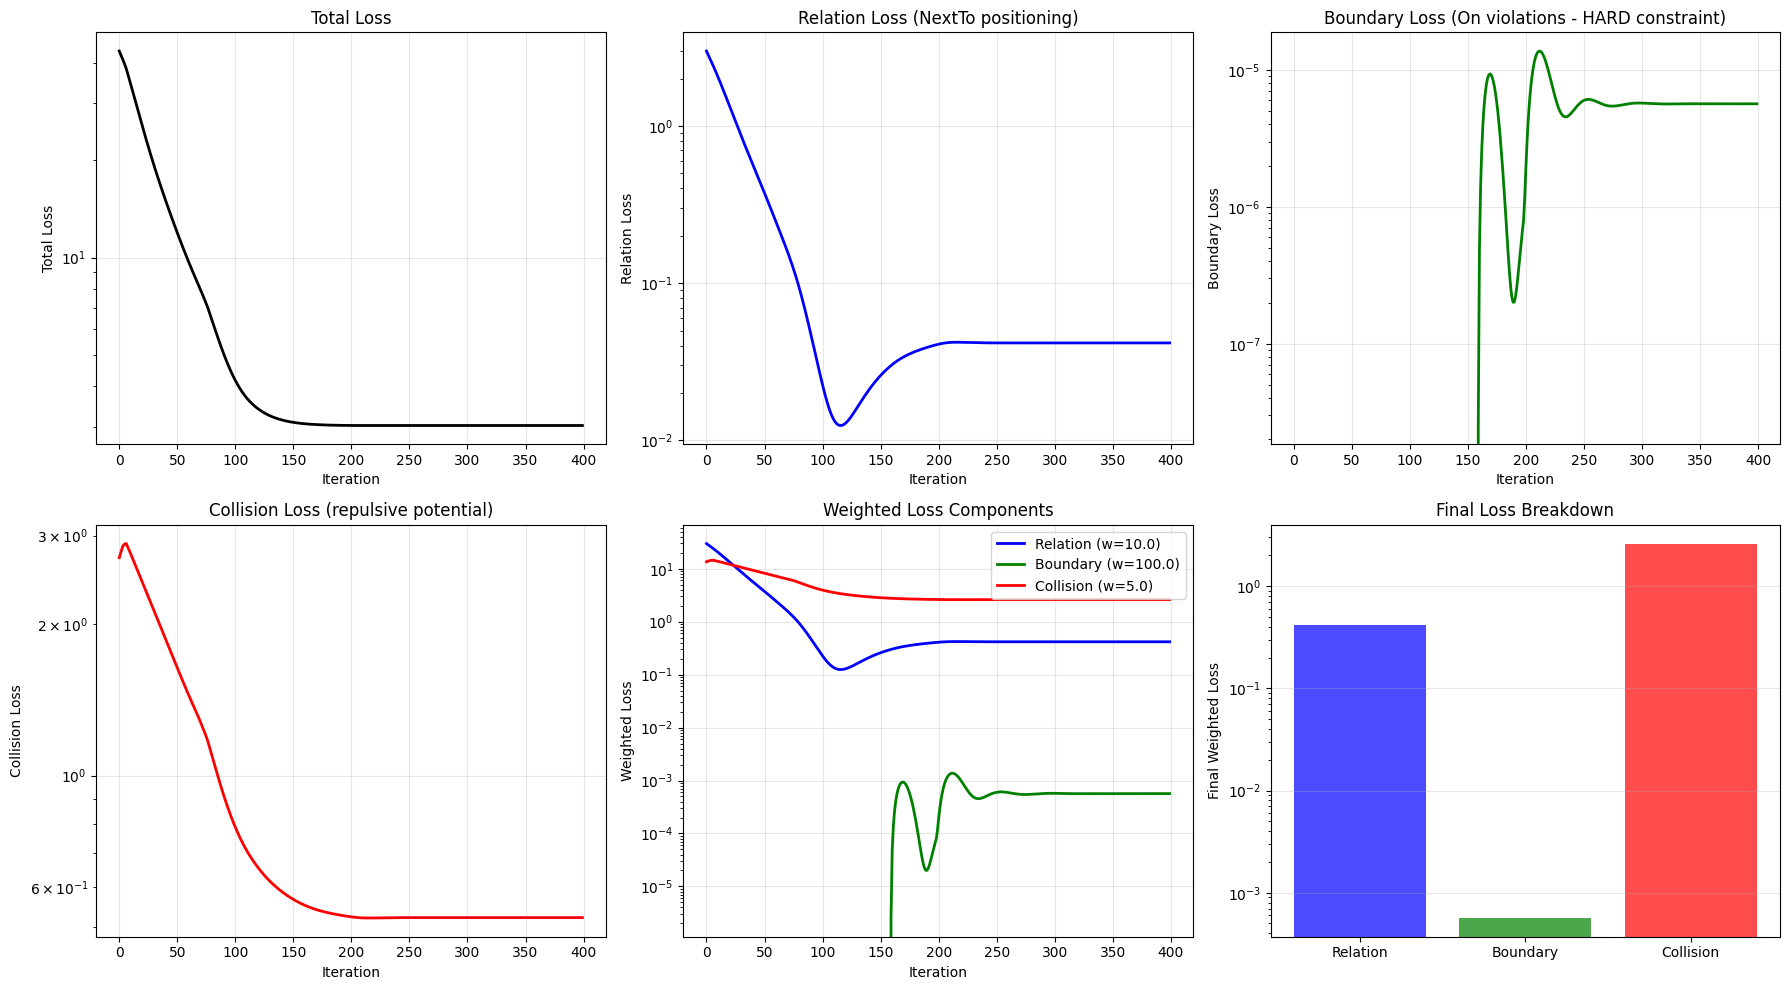


Loss component summary:
  Final total loss: 3.0273
  Final relation loss (unweighted): 0.0417
  Final boundary loss (unweighted): 0.0000
  Final collision loss (unweighted): 0.5219
  Final relation loss (weighted): 0.4172
  Final boundary loss (weighted): 0.0006
  Final collision loss (weighted): 2.6096


/tmp/ipykernel_1914/1963872995.py:269: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  anim.save(gif_path, writer=writer)



✅ GIF saved to: /tmp/spatial_relations_optimization.gif
   Frames: 40
   Duration: ~8.0 seconds at 5 FPS


/tmp/ipykernel_1914/1963872995.py:293: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/isaac-sim/kit/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


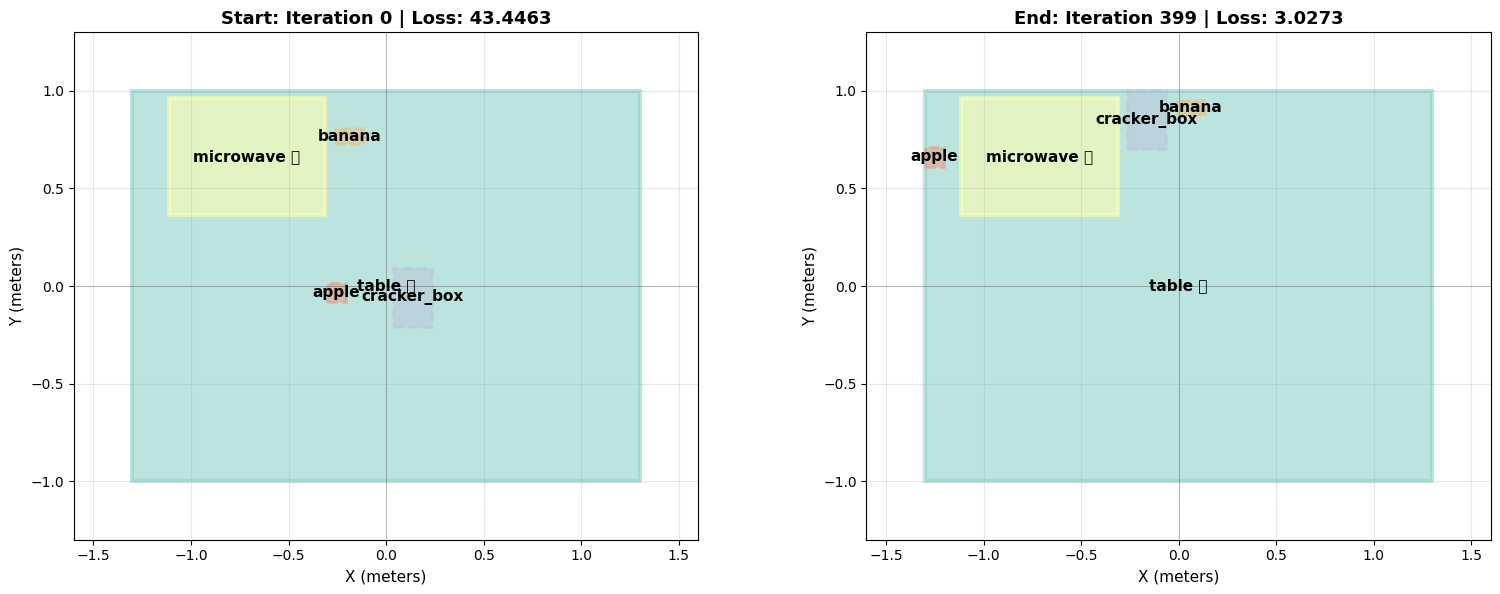


Observations:
- 📌 Fixed assets stay at their initial position
   └─ Table at origin (0, 0)
   └─ Microwave randomly initialized once, then fixed (acts as stable reference)
- Objects with On() relations are constrained to stay within table bounds
   └─ Cracker_box, apple, banana all remain on the table surface
- NextTo() relations position objects adjacent to the fixed microwave
   └─ Cracker box next to microwave (right), apple next to microwave (left)
   └─ Banana next to cracker box (right)
- Combined relations (On + NextTo) work together
   └─ e.g., Cracker box is both On(table) AND NextTo(microwave)
- Collision avoidance ensures objects don't overlap
- Converges to a stable layout with all objects on the table

Visualization Legend:
  📌 Solid border = Fixed asset (not optimized)
  -- Dashed border = Optimizable asset (moves during optimization)

Relations demonstrated:
  • On(parent): Keeps child within parent's bounds (hard boundary constraint)
  • NextTo(parent, side): Positions

In [65]:
# Create a solver that captures positions during optimization
class VisualizingSolver2D(RelationSolver2D):
    """Extended solver that captures positions and loss components at regular intervals."""
    
    def solve(self, assets: list[MockAsset2D], capture_interval=10):
        """Solve and capture positions at regular intervals."""
        # Initialize
        all_positions = self._initialize_positions(assets)
        
        # Identify fixed assets and optimizable assets
        fixed_mask = torch.tensor([asset.fixed for asset in assets])
        optimizable_mask = ~fixed_mask
        
        # Split into fixed and optimizable
        fixed_positions = all_positions[fixed_mask].clone()
        optimizable_positions = all_positions[optimizable_mask].clone()
        optimizable_positions.requires_grad = True
        
        optimizer = torch.optim.Adam([optimizable_positions], lr=self.lr)
        
        # Storage for visualization
        position_history = []
        loss_history = []
        relation_loss_history = []
        boundary_loss_history = []
        collision_loss_history = []
        
        # Optimization loop
        for iter in range(self.max_iters):
            optimizer.zero_grad()
            
            # Reconstruct full position tensor
            all_positions = torch.zeros((len(assets), 3))
            all_positions[fixed_mask] = fixed_positions
            all_positions[optimizable_mask] = optimizable_positions
            
            # Compute and store loss components
            rel_loss = self._compute_relation_loss(all_positions, assets)
            boundary_loss = self._compute_boundary_loss(all_positions, assets)
            col_loss = self._compute_collision_loss(all_positions, assets)
            loss = self.w_relation * rel_loss + self.w_boundary * boundary_loss + self.w_collision * col_loss
            
            loss_history.append(loss.item())
            relation_loss_history.append(rel_loss.item())
            boundary_loss_history.append(boundary_loss.item())
            collision_loss_history.append(col_loss.item())
            
            # Capture positions at intervals
            if iter % capture_interval == 0:
                position_history.append(all_positions.detach().clone().numpy())
            
            # Backprop and update
            loss.backward()
            optimizer.step()
            
            # Check convergence
            if loss.item() < self.convergence_threshold:
                if self.verbose:
                    print(f"Converged at iteration {iter}")
                # Capture final position
                final_pos = torch.zeros((len(assets), 3))
                final_pos[fixed_mask] = fixed_positions
                final_pos[optimizable_mask] = optimizable_positions.detach()
                position_history.append(final_pos.numpy())
                break
        
        # Ensure we captured the final position
        final_pos = torch.zeros((len(assets), 3))
        final_pos[fixed_mask] = fixed_positions
        final_pos[optimizable_mask] = optimizable_positions.detach()
        if len(position_history) == 0 or not np.allclose(position_history[-1], final_pos.numpy()):
            position_history.append(final_pos.numpy())
        
        return position_history, loss_history, relation_loss_history, boundary_loss_history, collision_loss_history, assets

# Create scenario with table and original Example 2 assets
# Table is the fixed anchor (explicitly marked as fixed)
table = MockAsset2D("table", width=2.6, length=2.0, fixed=True, initial_pos=(0.0, 0.0, 0.0))

# Microwave gets random initial position, then stays fixed as reference object
microwave_init_pos = (float(torch.randn(1).item() * 1.0), float(torch.randn(1).item() * 1.0), 0.0)
microwave = MockAsset2D("microwave", width=0.8, length=0.6, fixed=True, initial_pos=microwave_init_pos)

# Original assets from Example 2 (will be optimized)
cracker_box = MockAsset2D("cracker_box", width=0.2, length=0.3)
apple = MockAsset2D("apple", width=0.1, length=0.1)
banana = MockAsset2D("banana", width=0.15, length=0.08)

# Define relations combining On() and NextTo()
# - Microwave is fixed (randomly initialized once, won't move during optimization)
# - Other objects are On(table) AND positioned NextTo microwave

# MVP 2D Optimization
table = MockAsset2D("table", fixed=True)
microwave.add_relation(On(table), fixed=True)

cracker_box.add_relation(On(table), NextTo(microwave, side="right"))
apple.add_relation(On(table), NextTo(microwave, side="left"))
banana.add_relation(On(table), NextTo(cracker_box, side="right"))

assets_list = [table, microwave, cracker_box, apple, banana]

# Solve with position tracking (balanced weights: prioritize relations, enforce boundaries, avoid collisions)
# Key insight: w_boundary should be large enough to prevent violations but not so large it prevents relations
vis_solver = VisualizingSolver2D(w_relation=10.0, w_boundary=100.0, w_collision=5.0, max_iters=400, verbose=False)
position_history, loss_history, relation_loss_history, boundary_loss_history, collision_loss_history, assets = vis_solver.solve(assets_list, capture_interval=10)

print(f"Captured {len(position_history)} snapshots during optimization")

# Plot individual loss components
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Total loss
ax = axes[0, 0]
ax.plot(loss_history, linewidth=2, color='black')
ax.set_xlabel('Iteration')
ax.set_ylabel('Total Loss')
ax.set_title('Total Loss')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Relation loss (NextTo positioning)
ax = axes[0, 1]
ax.plot(relation_loss_history, linewidth=2, color='blue')
ax.set_xlabel('Iteration')
ax.set_ylabel('Relation Loss')
ax.set_title('Relation Loss (NextTo positioning)')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Boundary loss (hard constraint)
ax = axes[0, 2]
ax.plot(boundary_loss_history, linewidth=2, color='green')
ax.set_xlabel('Iteration')
ax.set_ylabel('Boundary Loss')
ax.set_title('Boundary Loss (On violations - HARD constraint)')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Collision loss
ax = axes[1, 0]
ax.plot(collision_loss_history, linewidth=2, color='red')
ax.set_xlabel('Iteration')
ax.set_ylabel('Collision Loss')
ax.set_title('Collision Loss (repulsive potential)')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Weighted comparison (all components)
ax = axes[1, 1]
ax.plot(np.array(relation_loss_history) * vis_solver.w_relation, 
        linewidth=2, color='blue', label=f'Relation (w={vis_solver.w_relation})')
ax.plot(np.array(boundary_loss_history) * vis_solver.w_boundary, 
        linewidth=2, color='green', label=f'Boundary (w={vis_solver.w_boundary})')
ax.plot(np.array(collision_loss_history) * vis_solver.w_collision, 
        linewidth=2, color='red', label=f'Collision (w={vis_solver.w_collision})')
ax.set_xlabel('Iteration')
ax.set_ylabel('Weighted Loss')
ax.set_title('Weighted Loss Components')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Loss components breakdown
ax = axes[1, 2]
final_rel = relation_loss_history[-1] * vis_solver.w_relation
final_bound = boundary_loss_history[-1] * vis_solver.w_boundary
final_col = collision_loss_history[-1] * vis_solver.w_collision
ax.bar(['Relation', 'Boundary', 'Collision'], [final_rel, final_bound, final_col], 
       color=['blue', 'green', 'red'], alpha=0.7)
ax.set_ylabel('Final Weighted Loss')
ax.set_title('Final Loss Breakdown')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nLoss component summary:")
print(f"  Final total loss: {loss_history[-1]:.4f}")
print(f"  Final relation loss (unweighted): {relation_loss_history[-1]:.4f}")
print(f"  Final boundary loss (unweighted): {boundary_loss_history[-1]:.4f}")
print(f"  Final collision loss (unweighted): {collision_loss_history[-1]:.4f}")
print(f"  Final relation loss (weighted): {final_rel:.4f}")
print(f"  Final boundary loss (weighted): {final_bound:.4f}")
print(f"  Final collision loss (weighted): {final_col:.4f}")

# Function to create a single frame
def create_frame(positions, assets, iter_num, loss_val, ax):
    """Draw a single frame of the optimization."""
    ax.clear()
    
    # Define colors for each asset (extended for 5 assets)
    colors = ['#8DD3C7', '#FFFFB3', '#BEBADA', '#FB8072', '#FDB462']
    
    # Draw each asset
    for i, asset in enumerate(assets):
        x, y, theta = positions[i]
        
        is_fixed = asset.fixed
        
        # Draw rectangle with thicker border for fixed assets
        rect = patches.Rectangle(
            (x - asset.width/2, y - asset.length/2),
            asset.width, asset.length,
            linewidth=3 if is_fixed else 2, 
            edgecolor=colors[i], 
            facecolor=colors[i], 
            alpha=0.6 if is_fixed else 0.4,
            linestyle='-' if is_fixed else '--'
        )
        ax.add_patch(rect)
        
        # Add label with marker for fixed assets
        label = f"{asset.name}" + (" 📌" if is_fixed else "")
        ax.text(x, y, label, ha='center', va='center', 
                fontweight='bold', fontsize=11)
    
    # Set plot properties
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linewidth=0.5, alpha=0.3)
    ax.axvline(x=0, color='k', linewidth=0.5, alpha=0.3)
    ax.set_xlabel('X (meters)', fontsize=11)
    ax.set_ylabel('Y (meters)', fontsize=11)
    # Set limits to show full table (2.6m x 2.0m) with some margin
    ax.set_xlim(-1.6, 1.6)
    ax.set_ylim(-1.3, 1.3)
    ax.set_title(f'Iteration {iter_num} | Loss: {loss_val:.4f}', 
                 fontsize=13, fontweight='bold')

# Create GIF using matplotlib animation
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(10, 8))

def animate(frame_idx):
    """Animation function called for each frame."""
    positions = position_history[frame_idx]
    
    # Calculate corresponding iteration number
    if frame_idx == len(position_history) - 1:
        iter_num = len(loss_history) - 1
    else:
        iter_num = frame_idx * 10
    
    loss_val = loss_history[min(iter_num, len(loss_history)-1)]
    
    create_frame(positions, assets, iter_num, loss_val, ax)
    return []

# Create animation
anim = FuncAnimation(fig, animate, frames=len(position_history), 
                     interval=200, repeat=True)

# Save as GIF with proper path handling
import os
import tempfile

# Try to save in the notebook's directory, otherwise use temp directory
gif_path = os.path.join(tempfile.gettempdir(), 'spatial_relations_optimization.gif')

# Remove existing file if it exists
if os.path.exists(gif_path):
    try:
        os.remove(gif_path)
    except:
        # If can't remove, try a different filename
        gif_path = os.path.join(tempfile.gettempdir(), f'spatial_relations_optimization_{os.getpid()}.gif')

try:
    writer = PillowWriter(fps=5)
    anim.save(gif_path, writer=writer)
    print(f"\n✅ GIF saved to: {gif_path}")
    print(f"   Frames: {len(position_history)}")
    print(f"   Duration: ~{len(position_history)/5:.1f} seconds at 5 FPS")
except Exception as e:
    print(f"\n⚠️  Could not save GIF: {e}")
    print(f"   Attempted path: {gif_path}")

plt.close(fig)

# Display the first and last frames as a preview
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# First frame
create_frame(position_history[0], assets, 0, loss_history[0], ax1)
ax1.set_title(f'Start: Iteration 0 | Loss: {loss_history[0]:.4f}', 
              fontsize=13, fontweight='bold')

# Last frame
final_iter = len(loss_history) - 1
create_frame(position_history[-1], assets, final_iter, loss_history[-1], ax2)
ax2.set_title(f'End: Iteration {final_iter} | Loss: {loss_history[-1]:.4f}', 
              fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- 📌 Fixed assets stay at their initial position")
print("   └─ Table at origin (0, 0)")
print("   └─ Microwave randomly initialized once, then fixed (acts as stable reference)")
print("- Objects with On() relations are constrained to stay within table bounds")
print("   └─ Cracker_box, apple, banana all remain on the table surface")
print("- NextTo() relations position objects adjacent to the fixed microwave")
print("   └─ Cracker box next to microwave (right), apple next to microwave (left)")
print("   └─ Banana next to cracker box (right)")
print("- Combined relations (On + NextTo) work together")
print("   └─ e.g., Cracker box is both On(table) AND NextTo(microwave)")
print("- Collision avoidance ensures objects don't overlap")
print("- Converges to a stable layout with all objects on the table")
print("\nVisualization Legend:")
print("  📌 Solid border = Fixed asset (not optimized)")
print("  -- Dashed border = Optimizable asset (moves during optimization)")
print("\nRelations demonstrated:")
print("  • On(parent): Keeps child within parent's bounds (hard boundary constraint)")
print("  • NextTo(parent, side): Positions child adjacent to parent")


In [ ]:
class Relation:
    """Base class for spatial relationships."""
    
    def __init__(self, parent: MockAsset2D):
        self.parent = parent
    
    def compute_loss(self, child_pos, parent_pos, child_asset, parent_asset) -> torch.Tensor:
        """Compute differentiable loss term for this relation."""
        raise NotImplementedError


class Asset:
    def __init__(self):
        self.relations = []

    def add_relation(self, relation: Relation):
        self.relations.append(relation)
        



class Solver():
    def __init__(self, assets: list[MockAsset2D]):